# synthetic validation


## 1. Real photocurrent, real PSCs

In [109]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import subtractr
import subtractr.photocurrent_sim as pcsim
import subtractr.psc_sim as psc_sim
import jax.random as jrand

import circuitmap as cm
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
from subtractr import utils
from functools import partial
from jax import vmap

In [2]:
net = subtractr.Subtractr.load_from_checkpoint('../subtractr/lightning_logs/version_500470/checkpoints/epoch=999-step=3125000.ckpt')
net = net.eval()

# Compare low-rank model to multi-trace model on simulated data

In [147]:

pc_fracs = np.arange(0.1, 1.0 + 0.1, 0.1)
iid_noise_levels = np.arange(0.01, 0.1 + 0.01, 0.01)
num_runs = 3

def create_formatted_df():
    df = pd.DataFrame(columns=['noise_level', 'pc_frac', 'method', 'run', 'mse', 'inputs', 'true_pscs'])
    df['true_pscs'] = df['true_pscs'].astype(object)
    df['inputs'] = df['inputs'].astype(object)

    return df


low_rank_mse = np.zeros((len(pc_fracs), len(iid_noise_levels), num_runs))
network_mse = np.zeros((len(pc_fracs), len(iid_noise_levels), num_runs))
num_runs = 5
df = create_formatted_df()
for i, frac in enumerate(pc_fracs):
    for j, noise in enumerate(iid_noise_levels):

        argstr = ("--num_train 10"
            # " --linear_onset_frac 0.5"
            " --pc_scale_min 0.1 --pc_scale_max 0.8"
            " --psc_scale_min 0.01 --psc_scale_max 0.5"
            " --min_pc_fraction %f --max_pc_fraction %f"
            " --max_pc_fraction 1.0"
            " --onset_latency_ms 0.0 --num_test %d"
            " --normalize none"
            " --onset_jitter_ms 1.0"
            " --gp_scale_max 0.01"
            " --gp_scale_min 0.01"
            " --num_traces_per_expt 64"
            " --iid_noise_std_min %f"
            " --iid_noise_std_max %f" % (frac, frac, num_runs, noise, noise))
        argstr = argstr.split(" ")
        args = subtractr.pc_subtractr_network.parse_args(argstr)

        dummy_net = subtractr.Subtractr(**vars(args))
        dummy_net.generate_training_data(args)

        for run_idx in range(num_runs):
            # each run here is its own simulated experiment
            inputs = np.array(dummy_net.test_expts[0][run_idx])
            true_pscs = np.array(dummy_net.test_expts[1][run_idx])

            # subtract photocurrent using trained net
            est = net(np.array(inputs))
            subtracted = inputs - est
            new_row = create_formatted_df()
            new_row.loc[0] = {'noise_level': noise, 'pc_frac': frac, 'method': 'network',
                'run': run_idx, 'mse': np.mean((est - true_pscs)**2),
                'inputs': inputs, 'true_pscs': true_pscs}
            df = pd.concat([df, new_row], ignore_index=True)


            # calculate mse using low-rank model
            est = subtractr.low_rank.estimate_photocurrents_baseline(inputs,
                None, separate_by_power=False, stepwise_constrain_V=False)
            subtracted = inputs - est
            new_row = create_formatted_df()
            new_row.loc[0] = {'noise_level': noise, 'pc_frac': frac, 'method': 'low-rank',
                'run': run_idx, 'mse': np.mean((est - true_pscs)**2),
                'inputs': inputs, 'true_pscs': true_pscs}
            df = pd.concat([df, new_row], ignore_index=True)



Running photocurrent removal...complete (elapsed time 0.13s, device=cpu).


/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/nmu.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  error_mu.append(np.linalg.norm(mu - mu_old) / np.linalg.norm(mu_old))
/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/nmu.py:208: RuntimeWarning: invalid value encountered in double_scalars
  error_mu.append(np.linalg.norm(mu - mu_old) / np.linalg.norm(mu_old))
/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/low_rank.py:53: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  V_post = np.linalg.lstsq(U_stim, pscs_truncated)[0]


ValueError: Data must be 1-dimensional

In [146]:
df = pd.DataFrame(columns=[1])
df[1] = df[1].astype(object)
df.loc[1, 1] = np.zeros((2, 2))
df

,1
1,"[[0.0, 0.0], [0.0, 0.0]]"


TypeError: unhashable type: 'DeviceArray'

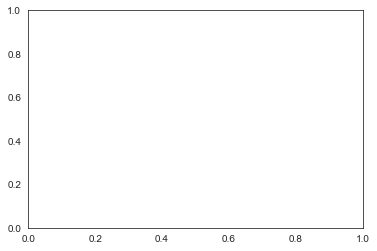

In [122]:
import seaborn as sns

sns.scatterplot(data=df, x='noise_level', y='mse', hue='method', style='pc_frac', s=100)

<AxesSubplot:xlabel='pc_frac', ylabel='mse'>

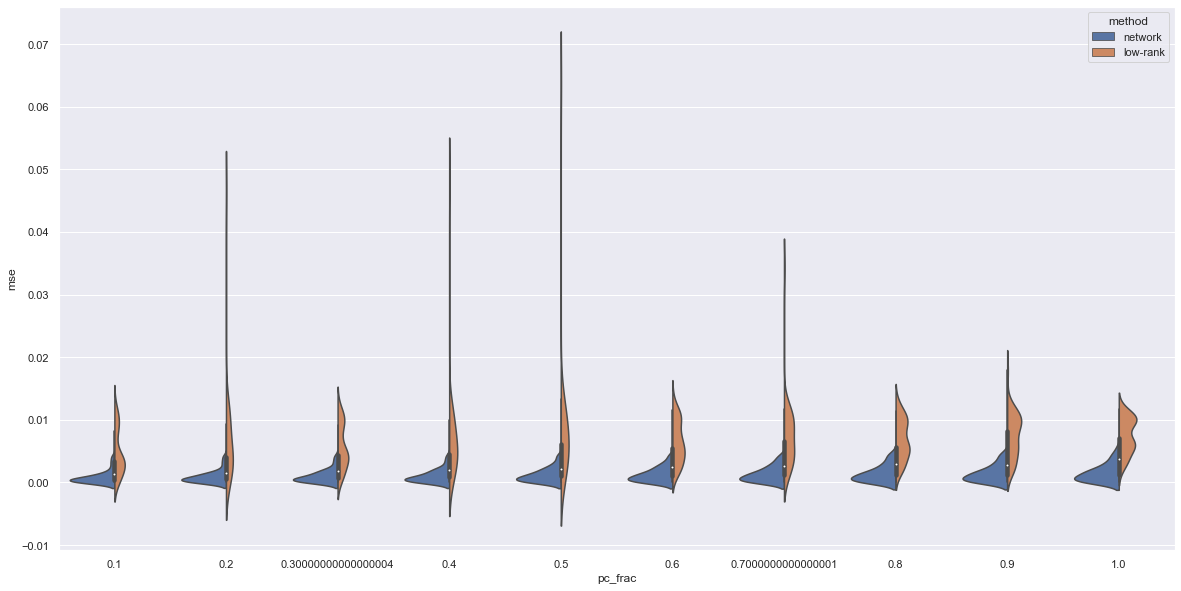

In [141]:
df2 = df.astype({'noise_level': 'float', 'pc_frac': float, 'method': str, 'run': int, 'mse': float})
# sns.scatterplot(data=df2, x='noise_level', y='mse', hue='method', s=100)

sns.set_context("notebook")
# sns.set(rc={"figure.figsize":(20, 10)})
sns.violinplot(data=df2, x='pc_frac', y='mse', hue='method', s=100, split=True)

Running photocurrent removal...complete (elapsed time 0.13s, device=cpu).


/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/pc_subtractr_network.py:193: RuntimeWarning: invalid value encountered in true_divide
  (traces/maxv), dtype=torch.float32, device=self.device
/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/nmu.py:208: RuntimeWarning: divide by zero encountered in double_scalars
  error_mu.append(np.linalg.norm(mu - mu_old) / np.linalg.norm(mu_old))
/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/nmu.py:208: RuntimeWarning: invalid value encountered in double_scalars
  error_mu.append(np.linalg.norm(mu - mu_old) / np.linalg.norm(mu_old))
/Users/bantin/Documents/Columbia/Projects/2p-opto/mbcs_grids/subtractr/low_rank.py:53: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pas

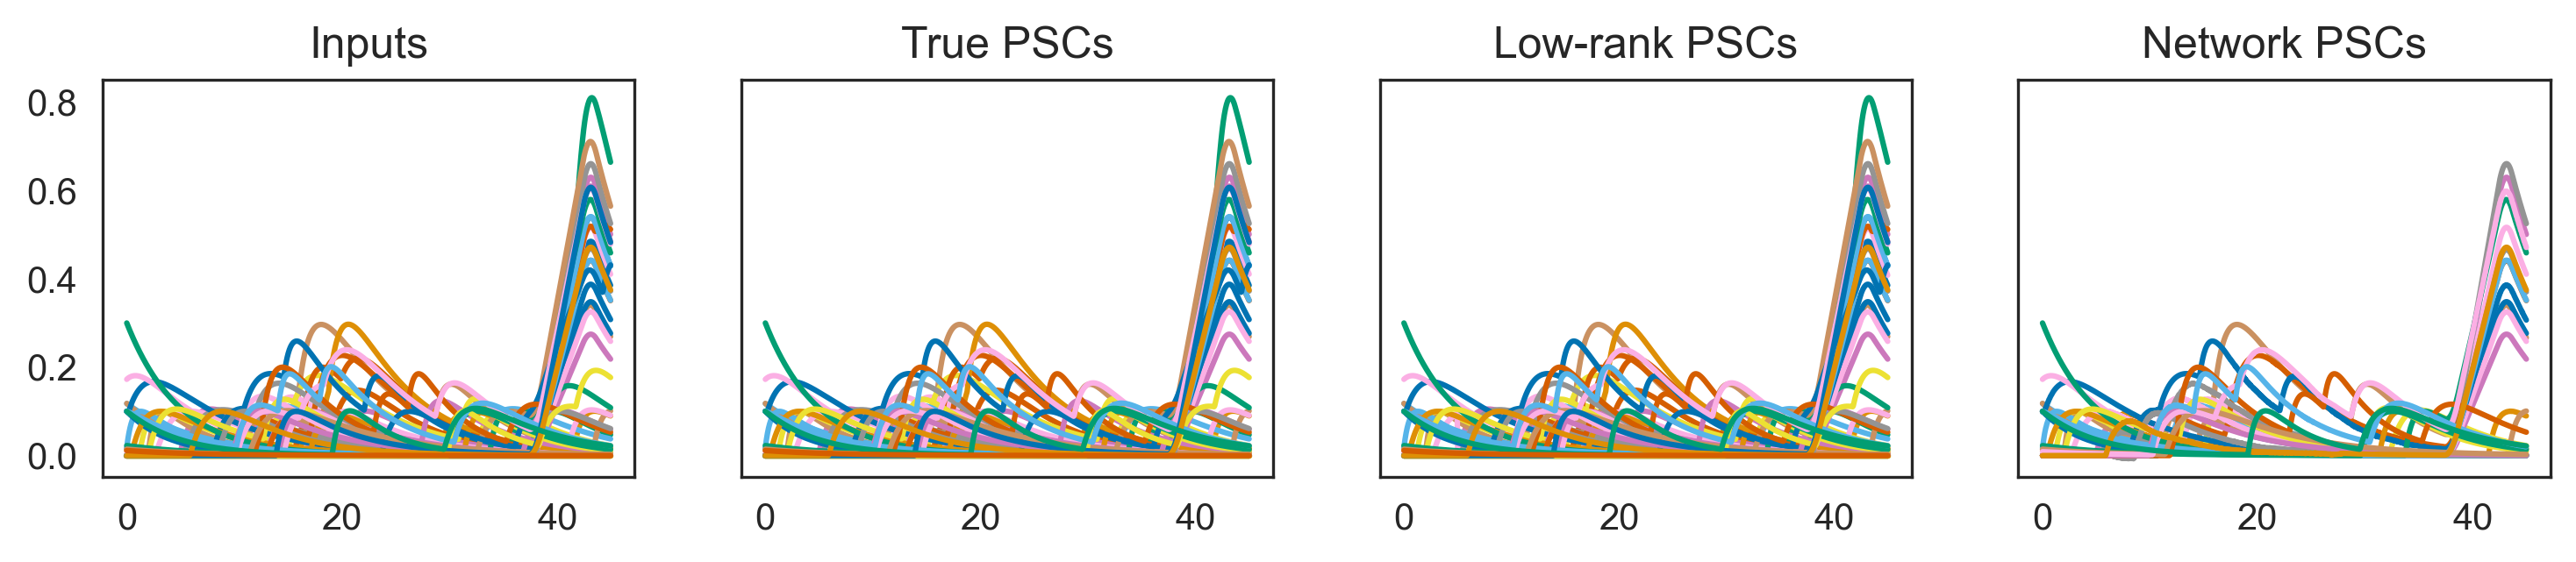

In [92]:

import seaborn as sns
sns.set_style('white')
sns.set_palette('colorblind')
amp = 0.1
pc_frac = 0.001
argstr = ("--num_train 10"
        " --linear_onset_frac 0.5"
        " --pc_scale_min 0.2 --pc_scale_max 0.8"
        " --psc_scale_min %f --psc_scale_max %f"
        " --min_pc_fraction %f"
        " --max_pc_fraction %f"
        " --onset_latency_ms 0.0 --num_test 1"
        " --normalize none"
        " --onset_jitter_ms 0.0001"
        " --gp_scale_max 0.00"
        " --gp_scale_min 0.00"
        " --num_traces_per_expt 64 --iid_noise_std_min 0.000"
        " --iid_noise_std_max 0.00" % (amp, amp, pc_frac, pc_frac))
argstr = argstr.split(" ")
args = subtractr.pc_subtractr_network.parse_args(argstr)

dummy_net = subtractr.Subtractr(**vars(args))
dummy_net.generate_training_data(args)

# subtract photocurrent using trained net
test_expts = dummy_net.test_expts
inputs = np.array(test_expts[0][0])
targets = test_expts[1][0]
true_pscs = inputs - targets

# estimate via net
net_pscs = inputs - net(inputs)

# estimate via low-rank
low_rank_pscs = inputs - subtractr.low_rank.estimate_photocurrents_baseline(inputs, None, separate_by_power=False, stepwise_constrain_V=False)

fig, axs = plt.subplots(1, 4, figsize=(12, 2), dpi=300, sharey=True)
tsteps = np.arange(inputs.shape[1]) * 0.05
axs[0].plot(tsteps, inputs.T)
axs[0].set_title('Inputs')
axs[1].plot(tsteps, true_pscs.T)
axs[1].set_title('True PSCs')

axs[2].plot(tsteps, low_rank_pscs.T)
axs[2].set_title('Low-rank PSCs')

axs[3].plot(tsteps, net_pscs.T)
axs[3].set_title('Network PSCs')
plt.show()